[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/amplpy/blob/master/notebooks/efficient_frontier.ipynb)

### Install needed modules and authenticate user to use google sheets

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install -q amplpy ampltools gspread --upgrade

     |████████████████████████████████| 4.1 MB 5.4 MB/s 


### Google Colab & Kaggle interagration

In [3]:
MODULES=['ampl', 'cplex']
from ampltools import cloud_platform_name, ampl_notebook
from amplpy import AMPL, register_magics
if cloud_platform_name() is None:
    ampl = AMPL() # Use local installation of AMPL
else:
    ampl = ampl_notebook(modules=MODULES) # Install AMPL and use it
register_magics(ampl_object=ampl) # Evaluate %%ampl_eval cells with ampl.eval()

Downloading: https://portal.ampl.com/dl/modules/ampl-module.linux64.tgz
> /content/ampl.linux-intel64/README (new)
> /content/ampl.linux-intel64/amplkey (new)
> /content/ampl.linux-intel64/amplxl.dll (new)
> /content/ampl.linux-intel64/ampl.env (new)
> /content/ampl.linux-intel64/models (new)
> /content/ampl.linux-intel64/ampl.lic (new)
> /content/ampl.linux-intel64/docs (new)
> /content/ampl.linux-intel64/ampl (new)
> /content/ampl.linux-intel64/leasefingerprint (new)
> /content/ampl.linux-intel64/fingerprint (new)
Downloading: https://portal.ampl.com/dl/modules/cplex-module.linux64.tgz
> /content/ampl.linux-intel64/cplex (new)
> /content/ampl.linux-intel64/docs (replacing)
> /content/ampl.linux-intel64/libcplex2010.so (new)
AMPL License:


### Auxiliar functions


In [4]:
import gspread
from google.auth import default
creds, _ = default()
gclient = gspread.authorize(creds)

def open_spreedsheet(name):
    if name.startswith('https://'):
        return gclient.open_by_url(name)
    return gclient.open(name)

import pandas as pd

def get_worksheet_values(name):
    return spreedsheet.worksheet(name).get_values(value_render_option='UNFORMATTED_VALUE')

def table_to_dataframe(rows):
    return pd.DataFrame(rows[1:], columns=rows[0]).set_index(rows[0][0])

def matrix_to_dataframe(rows, tr=False, nameOverride = None):
    col_labels = rows[0][1:]
    row_labels = [row[0] for row in rows[1:]]
    def label(pair):
        return pair if not tr else (pair[1], pair[0])
    data = {
        label((rlabel, clabel)): rows[i+1][j+1]
        for i, rlabel in enumerate(row_labels)
        for j, clabel in enumerate(col_labels)}
    df = pd.Series(data).reset_index()
    name = nameOverride if nameOverride else rows[0][0]
    df.columns = ['index1', 'index2', name]
    return df.set_index(['index1', 'index2'])

### Efficient Frontier Example

Open connection to the spreadsheet and get the data, using the utility functions in ampltools to get pandas dataframes.

In [5]:
spreedsheet = open_spreedsheet("https://docs.google.com/spreadsheets/d/1d9wRk2PJgYsjiNVoKi1FcawGSVUB5mxSeQUBdEleUv4/edit?usp=sharing")

rows = get_worksheet_values('covariance')
# To be able to use ampl.set_data, we override the data column 
# of the dataframe to the name of the parameter we will be setting (S)
covar = matrix_to_dataframe(rows, nameOverride = "S")

rows = get_worksheet_values('expectedReturns')
expected = table_to_dataframe(rows)

The following is a version of Markowitz mean-variance model, that can be used to calculate the efficient frontier

In [6]:
%%ampl_eval

set A ordered;         # assets

param S{A, A};         # cov matrix
param mu{A} default 0; # expected returns
param lb default 0;
param ub default Infinity;
param targetReturn default -Infinity;

var w{A} >= lb <= ub;  # weights
var portfolioReturn >= targetReturn;

minimize portfolio_variance: sum {i in A, j in A} S[i, j] * w[i] * w[j];
maximize portfolio_return: sum{a in A} mu[a] * w[a];

s.t. def_total_weight: sum {i in A}  w[i] = 1;
s.t. def_target_return: sum{a in A} mu[a] * w[a] >= targetReturn;

Using amplpy we set the data of the ampl entities using the dataframes we got from google sheets

In [7]:
# Set expected returns
ampl.set_data(expected, set_name="A")
# Set covariance data
ampl.set_data(covar)


Set a few options in AMPL to streamline the execution

In [8]:
%%ampl_eval
# Set options
option solver cplex;
option solver_msg 0;

# The following declarations are needed for the efficient frontier script
param nPoints := 20;
param minReturn;
param maxReturn;
param variances{1..nPoints+1};
param returns{1..nPoints+1};
param delta = (maxReturn-minReturn)/nPoints;

Calculate the extreme points for the efficient frontier procedure: get the minimum return by solving the min varance problem, then get the maximum return by solving the max return problem.

In [9]:
%%ampl_eval
# Solve the min variance problem to get the minimum return
objective portfolio_variance;
solve > NUL;
printf "Min portfolio variance: %f, return: %f\n", portfolio_variance, portfolio_return;

let minReturn := portfolio_return;
# Store the first data point in the efficient frontier
let variances[1] := portfolio_variance;
let returns[1] := minReturn;

# Solve the max return problem
objective portfolio_return;
solve > NUL;
printf "Max portfolio variance: %f, return: %f", portfolio_variance, portfolio_return;
let maxReturn := portfolio_return;

Min portfolio variance: 0.000092, return: 0.001530
Max portfolio variance: 0.000249, return: 0.002182

Now that we have the upper and lower values for the expected returns, iterate `nPoints` times setting the desired return at regularly increasing levels and solve the min variance problem, thus getting the points (return - variance) needed to plot the efficient frontier.

In [10]:
%%ampl_eval

# Switch objective to portfolio variance
objective portfolio_variance;

# Set starting point
let targetReturn := minReturn;
# Calculate the efficient frontier
for{j in 1..nPoints}
{
	let targetReturn := targetReturn+delta;
  solve > NUL;
  printf "Return %f, variance %f\n", portfolio_return, portfolio_variance;
  let returns[j+1] := portfolio_return;
	let variances[j+1]:=portfolio_variance;
};

Return 0.001563, variance 0.000092
Return 0.001596, variance 0.000092
Return 0.001628, variance 0.000092
Return 0.001661, variance 0.000093
Return 0.001693, variance 0.000093
Return 0.001726, variance 0.000094
Return 0.001758, variance 0.000094
Return 0.001791, variance 0.000095
Return 0.001823, variance 0.000096
Return 0.001856, variance 0.000097
Return 0.001889, variance 0.000099
Return 0.001921, variance 0.000100
Return 0.001954, variance 0.000101
Return 0.001986, variance 0.000104
Return 0.002019, variance 0.000110
Return 0.002051, variance 0.000118
Return 0.002084, variance 0.000129
Return 0.002116, variance 0.000144
Return 0.002149, variance 0.000182
Return 0.002182, variance 0.000249


Finally, we plot the efficient frontier

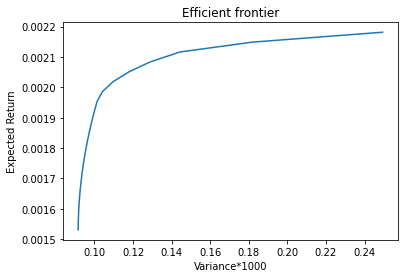

In [11]:
import matplotlib.pyplot as plt
df = ampl.get_data('returns', 'variances').toPandas()
plt.plot(df.variances*1000, df.returns)
plt.xlabel("Variance*1000")
plt.ylabel("Expected Return")
plt.title("Efficient frontier")
plt.show()
